# Regridded TRENDY

In [62]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [63]:
# Set the directories of the cluster and regridded data
regrid_dir = "/Net/Groups/BSI/work_scratch/ecathain/mpi2/TRENDY/Raw/OUTPUT"
cluster_dir = "/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/trendy/gcb2024/LAND/OUTPUT"

# Create directory to save plots
plot_dir = "/Net/Groups/BSI/work_scratch/ecathain/mpi2/Outputs/Variable_Selection/"

if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)

In [64]:
# Set all the variables and models to use

models_unfiltered = [
    "CABLE-POP", "CARDAMOM", "CLASSIC", "CLM5.0", "DLEM", "ED", "ELM", "IBIS",
    "iMAPLE", "ISAM", "ISBA-CTRIP", "JSBACH", "JULES", "LPJ-GUESS", "LPJml",
    "LPJwsl", "LPX", "OCN", "ORCHIDEE", "SDGVM", "VISIT", "VISIT-UT"
]

models_to_remove=['CARDAMOM', 'ISBA-CTRIP', 'DLEM', 'ISAM']

variables_unfiltered = [
    "pr", "rsds", "mrso", "mrro", "evapotrans", "evapotranspft", "transpft", "evapo", "albedopft", "snow_depthpft", "shflxpft", "rnpft",
    "cVeg", "cLitter", "cSoil", "cProduct", "cVegpft", "cSoilpft",
    "gpp", "ra", "npp", "rh", "fFire",
    "fLuc", "soilr", "nbp",
    "gpppft", "npppft", "rhpft", "nbppft",
    "landCoverFrac", "oceanCoverFrac", "burntArea", "lai", "laipft",
    "cLeaf", "cWood", "cRoot", "cCwd", "cSoilpools",
    "fVegLitter", "fLeafLitter", "fWoodLitter", "fRootLitter", "fLitterSoil", "fVegSoil", "rhpool",
    "fAllocLeaf", "fAllocWood", "fAllocRoot", "fFireCveg", "fFireLitter", "fFireCsoil"
]

variables_to_remove = [
    "evapotranspft", "transpft", "albedopft",
    "snow_depthpft", "shflxpft", "rnpft", "cSoilpft",
    "rhpft", "nbppft", "oceanCoverFrac", "cCwd", "cSoilpools",
    "fVegLitter", "fLeafLitter", "fWoodLitter", "fRootLitter",
    "fLitterSoil", "fVegSoil", "rhpool", "fAllocLeaf",
    "fAllocWood", "fAllocRoot", "fFireCveg", "fFireLitter",
    "fFireCsoil", "gpppft", "npppft", 'cVegpft', 'cProduct', 'laipft', 'cLeaf', 'cWood', 'cRoot', 'soilr', 'pr', 'rsds'
]

variables_filtered = variables_unfiltered.copy()
for i in variables_to_remove:
    variables_filtered.remove(i)

models_filtered = models_unfiltered.copy()
for i in models_to_remove:
    models_filtered.remove(i)

# Store them as an iterable dictionary
models_list = [models_unfiltered, models_filtered]
variables_list = [variables_unfiltered, variables_filtered]

In [65]:
models_filtered

['CABLE-POP',
 'CLASSIC',
 'CLM5.0',
 'ED',
 'ELM',
 'IBIS',
 'iMAPLE',
 'JSBACH',
 'JULES',
 'LPJ-GUESS',
 'LPJml',
 'LPJwsl',
 'LPX',
 'OCN',
 'ORCHIDEE',
 'SDGVM',
 'VISIT',
 'VISIT-UT']

### Loop through both the cluster and regridded data and extract all the file names

First create a dataframe for each checking if all the priority variables are present.

Then it creates a dataframe comparing if they match.

In [66]:
# Create dictionary to store output in
dict_outcomes = {'unfiltered': [], 'filtered':[]}

# Loop through the models and variables list while also counting
# The first iteration will be unfiltered, second will be filtered
for counter, (models, vars) in enumerate(zip(models_list, variables_list)):
    
    # Store the paths as an iterable object
    dirs = [regrid_dir, cluster_dir]

    df_true_list = []
    df_dict_scenario_files_list = []

    for dir in dirs:
        ### Create a dictionary of models and scenarios 
        models_scenarios = {}

        scenarios = ['S0','S1', 'S2', 'S3']

        # If you include cardamom:
        if 'CARDAMOM' in models:
            scenarios_cardamom = ['S0/CARDAMOM','S1/CARDAMOM', 'S2/CARDAMOM', 'S3/CARDAMOM']

        # Because the file structure of CARDAMOM is different in the cluster we have to do this:
        for model in models:
            if model == 'CARDAMOM' and "BGI" in dir:
                models_scenarios[model] = scenarios_cardamom
            else:
                models_scenarios[model] = scenarios
        
        ### Create a dictionary of the models, scenarios and the files contained within each
        full_dict = {}

        for model, scenario_list in models_scenarios.items():
            full_dict[model] = {}
            for scenario in scenario_list:
                list_cdf = []
                scenario_path = os.path.join(dir, model, scenario)  
                if os.path.isdir(scenario_path):
                    list_cdf = os.listdir(scenario_path)
                full_dict[model][scenario] = list_cdf
            
        ### Convert it into a dictionary containing the scenario and the model as the key and the variables as the value
        dict_scenario_files = {}

        for model, scenario_dict in full_dict.items():
            for scenario, cdf in scenario_dict.items():
                dict_scenario_files[f"{model}_{scenario}"] = cdf

        df_true = pd.DataFrame(index=vars)
        
        # This loops through the scenarios and the list of CDF files and creates a new dictionary which compiles the model and scenario names together
        for scenario, cdf_list in dict_scenario_files.items():
            df_true[scenario] = 'FALSE'
            for idx in df_true.index:
                for item in cdf_list:
                    if idx in item:
                        df_true.at[idx, scenario] = 'TRUE'
                        break  # No need to keep checking once found

        df_dict_scenario_files_list.append(dict_scenario_files)
        df_true_list.append(df_true)

# Rename the CARDAMOM from the cluster back again
    if 'CARDAMOM' in models:
        df_true_list[1].rename(columns={'CARDAMOM_S0/CARDAMOM': 'CARDAMOM_S0'}, inplace=True)
        df_true_list[1].rename(columns={'CARDAMOM_S1/CARDAMOM': 'CARDAMOM_S1'}, inplace=True)
        df_true_list[1].rename(columns={'CARDAMOM_S2/CARDAMOM': 'CARDAMOM_S2'}, inplace=True)
        df_true_list[1].rename(columns={'CARDAMOM_S3/CARDAMOM': 'CARDAMOM_S3'}, inplace=True)

    # Create a new DF comparing the cluster and the regridded files
    df_match = df_true_list[0] == df_true_list[1]

    if counter == 0:
        dict_outcomes['unfiltered']=[df_true_list[0], df_true_list[1], df_match]
    else:
        dict_outcomes['filtered']=[df_true_list[0], df_true_list[1], df_match]

In [67]:
dict_outcomes['filtered'][0]

,CABLE-POP_S0,CABLE-POP_S1,CABLE-POP_S2,CABLE-POP_S3,CLASSIC_S0,CLASSIC_S1,CLASSIC_S2,CLASSIC_S3,CLM5.0_S0,CLM5.0_S1,...,SDGVM_S2,SDGVM_S3,VISIT_S0,VISIT_S1,VISIT_S2,VISIT_S3,VISIT-UT_S0,VISIT-UT_S1,VISIT-UT_S2,VISIT-UT_S3
mrso,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,...,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
mrro,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,...,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
evapotrans,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,...,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
evapo,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,...,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
cVeg,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,...,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
cLitter,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,...,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
cSoil,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,...,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
gpp,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,...,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
ra,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,...,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
npp,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,...,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE


# Filtered Variables and Models
### Regridded Availability

/tmp/ipykernel_819164/741343610.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_data = dict_outcomes['filtered'][0].replace({'TRUE': 1, 'FALSE': 0})


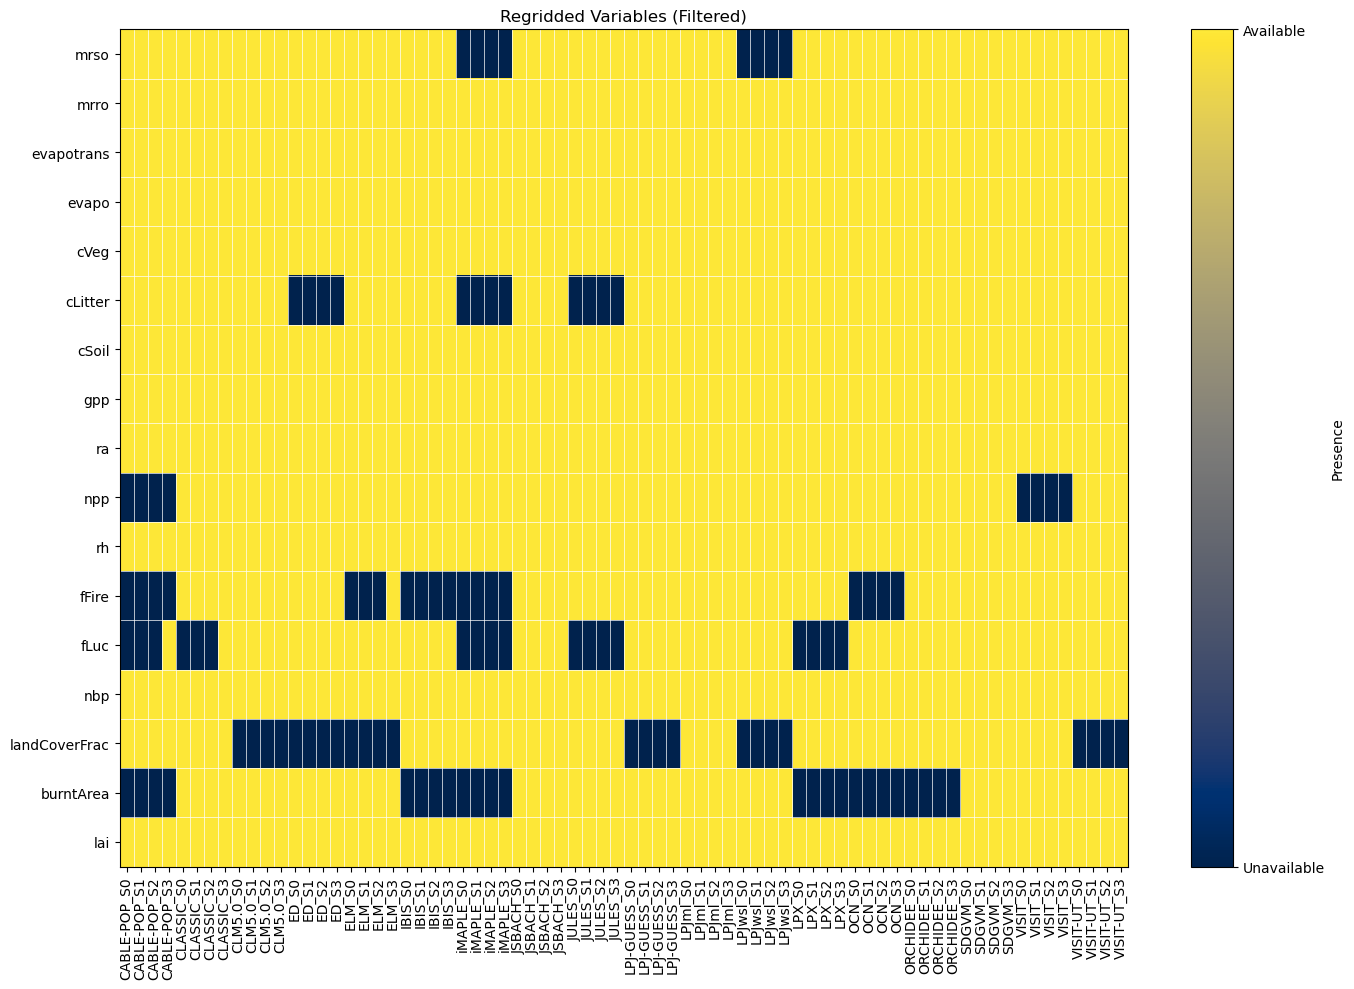

In [68]:
# Convert TRUE/FALSE to integers
plot_data = dict_outcomes['filtered'][0].replace({'TRUE': 1, 'FALSE': 0})

plt.figure(figsize=(14, 10))
cmap = plt.get_cmap('cividis')

# Plot heatmap
plt.imshow(plot_data, cmap=cmap, aspect='auto', interpolation='none')

# Tick labels
plt.xticks(ticks=np.arange(plot_data.shape[1]), labels=plot_data.columns, rotation=90)
plt.yticks(ticks=np.arange(plot_data.shape[0]), labels=plot_data.index, rotation=0)

# Add grid lines between cells
for x in range(plot_data.shape[1] + 1):
    plt.axvline(x - 0.5, color='white', linewidth=0.5)
for y in range(plot_data.shape[0] + 1):
    plt.axhline(y - 0.5, color='white', linewidth=0.5)

cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['Unavailable', 'Available'])
cbar.set_label('Presence')


plt.title("Regridded Variables (Filtered)")
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, "Filtered/Regridded_variables_filtered.png"))

plt.show()

/tmp/ipykernel_819164/609488097.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_data = dict_outcomes['filtered'][1].replace({'TRUE': 1, 'FALSE': 0})


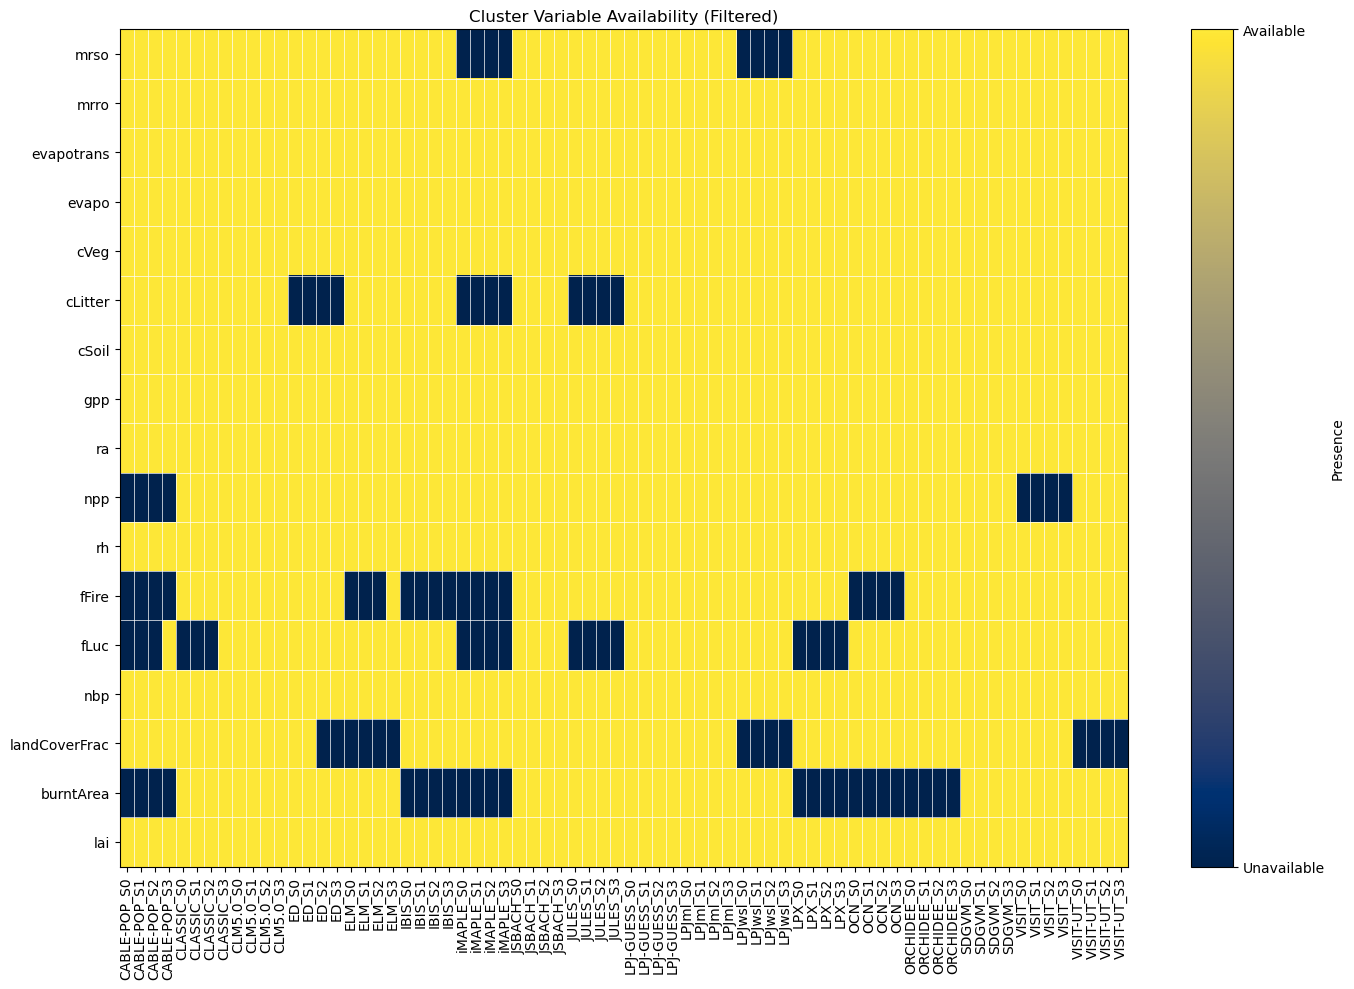

In [69]:
# Convert TRUE/FALSE to integers
plot_data = dict_outcomes['filtered'][1].replace({'TRUE': 1, 'FALSE': 0})

plt.figure(figsize=(14, 10))
cmap = plt.get_cmap('cividis')

# Plot heatmap
plt.imshow(plot_data, cmap=cmap, aspect='auto', interpolation='none')

# Tick labels
plt.xticks(ticks=np.arange(plot_data.shape[1]), labels=plot_data.columns, rotation=90)
plt.yticks(ticks=np.arange(plot_data.shape[0]), labels=plot_data.index, rotation=0)

# Add grid lines between cells
for x in range(plot_data.shape[1] + 1):
    plt.axvline(x - 0.5, color='white', linewidth=0.5)
for y in range(plot_data.shape[0] + 1):
    plt.axhline(y - 0.5, color='white', linewidth=0.5)

cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['Unavailable', 'Available'])
cbar.set_label('Presence')

plt.title("Cluster Variable Availability (Filtered)")
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, "Filtered/Cluster_variables_filtered.png"))

plt.show()

### Match Between Cluster and Regridded Availability

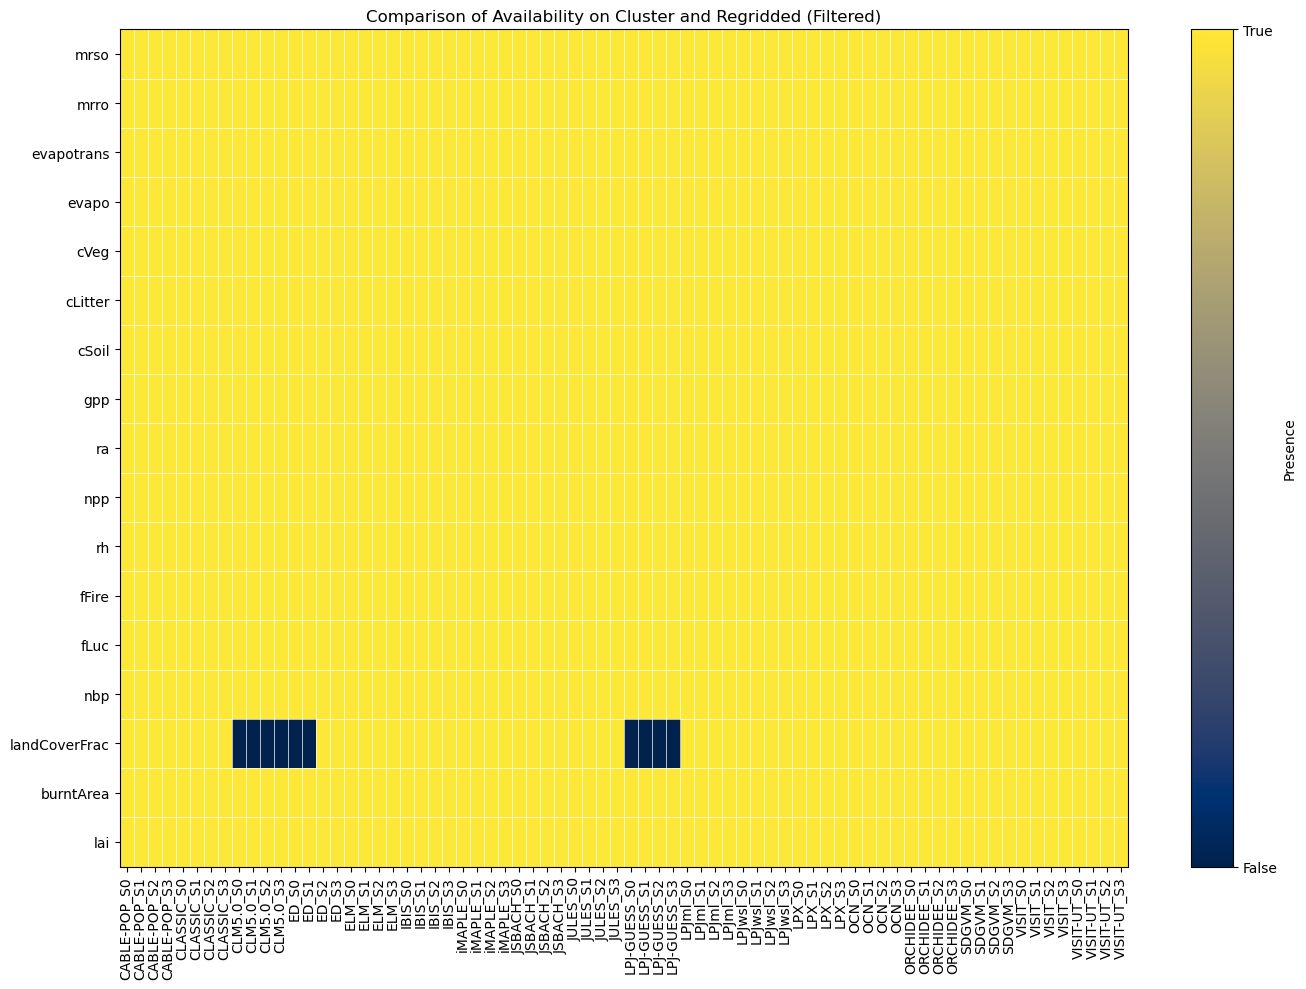

In [70]:
plt.figure(figsize=(14, 10))
cmap = plt.get_cmap('cividis')

# Plot heatmap using boolean values (converted to float for imshow)
plt.imshow(dict_outcomes['filtered'][2].values.astype(float), cmap=cmap, aspect='auto', interpolation='none')

# Tick labels
plt.xticks(ticks=np.arange(dict_outcomes['filtered'][2].shape[1]), labels=dict_outcomes['filtered'][2].columns, rotation=90)
plt.yticks(ticks=np.arange(dict_outcomes['filtered'][2].shape[0]), labels=dict_outcomes['filtered'][2].index, rotation=0)

# Add grid lines between cells
for x in range(dict_outcomes['filtered'][2].shape[1] + 1):
    plt.axvline(x - 0.5, color='white', linewidth=0.5)
for y in range(dict_outcomes['filtered'][2].shape[0] + 1):
    plt.axhline(y - 0.5, color='white', linewidth=0.5)

# Colorbar
cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['False', 'True'])
cbar.set_label('Presence')

plt.title("Comparison of Availability on Cluster and Regridded (Filtered)")

plt.savefig(os.path.join(plot_dir, "Filtered/Regridded_Cluster_match_filtered.png"))

plt.tight_layout()
plt.show()

# Unfiltered Variables 
### Regridded Availability

/tmp/ipykernel_819164/2816822240.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_data = dict_outcomes['unfiltered'][0].replace({'TRUE': 1, 'FALSE': 0})


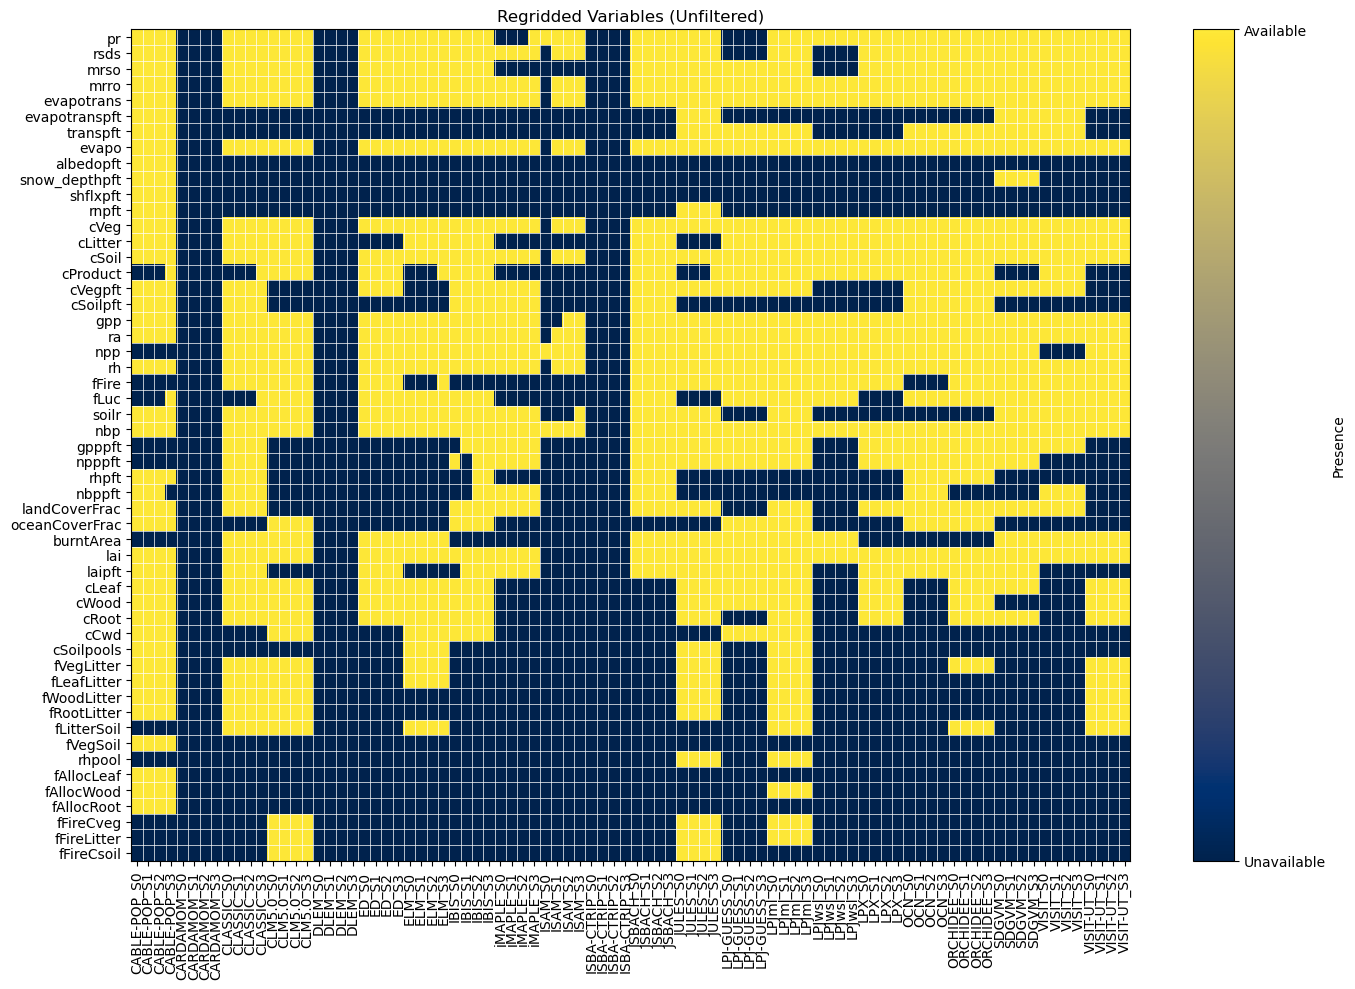

In [71]:
# Convert TRUE/FALSE to integers
plot_data = dict_outcomes['unfiltered'][0].replace({'TRUE': 1, 'FALSE': 0})

plt.figure(figsize=(14, 10))
cmap = plt.get_cmap('cividis')

# Plot heatmap
plt.imshow(plot_data, cmap=cmap, aspect='auto', interpolation='none')

# Tick labels
plt.xticks(ticks=np.arange(plot_data.shape[1]), labels=plot_data.columns, rotation=90)
plt.yticks(ticks=np.arange(plot_data.shape[0]), labels=plot_data.index, rotation=0)

# Add grid lines between cells
for x in range(plot_data.shape[1] + 1):
    plt.axvline(x - 0.5, color='white', linewidth=0.5)
for y in range(plot_data.shape[0] + 1):
    plt.axhline(y - 0.5, color='white', linewidth=0.5)

cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['Unavailable', 'Available'])
cbar.set_label('Presence')


plt.title("Regridded Variables (Unfiltered)")
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, "Unfiltered/Regridded_variables_unfiltered.png"))

plt.show()

### Unfiltered Variables on Cluster

/tmp/ipykernel_819164/2244328000.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_data = dict_outcomes['unfiltered'][1].replace({'TRUE': 1, 'FALSE': 0})


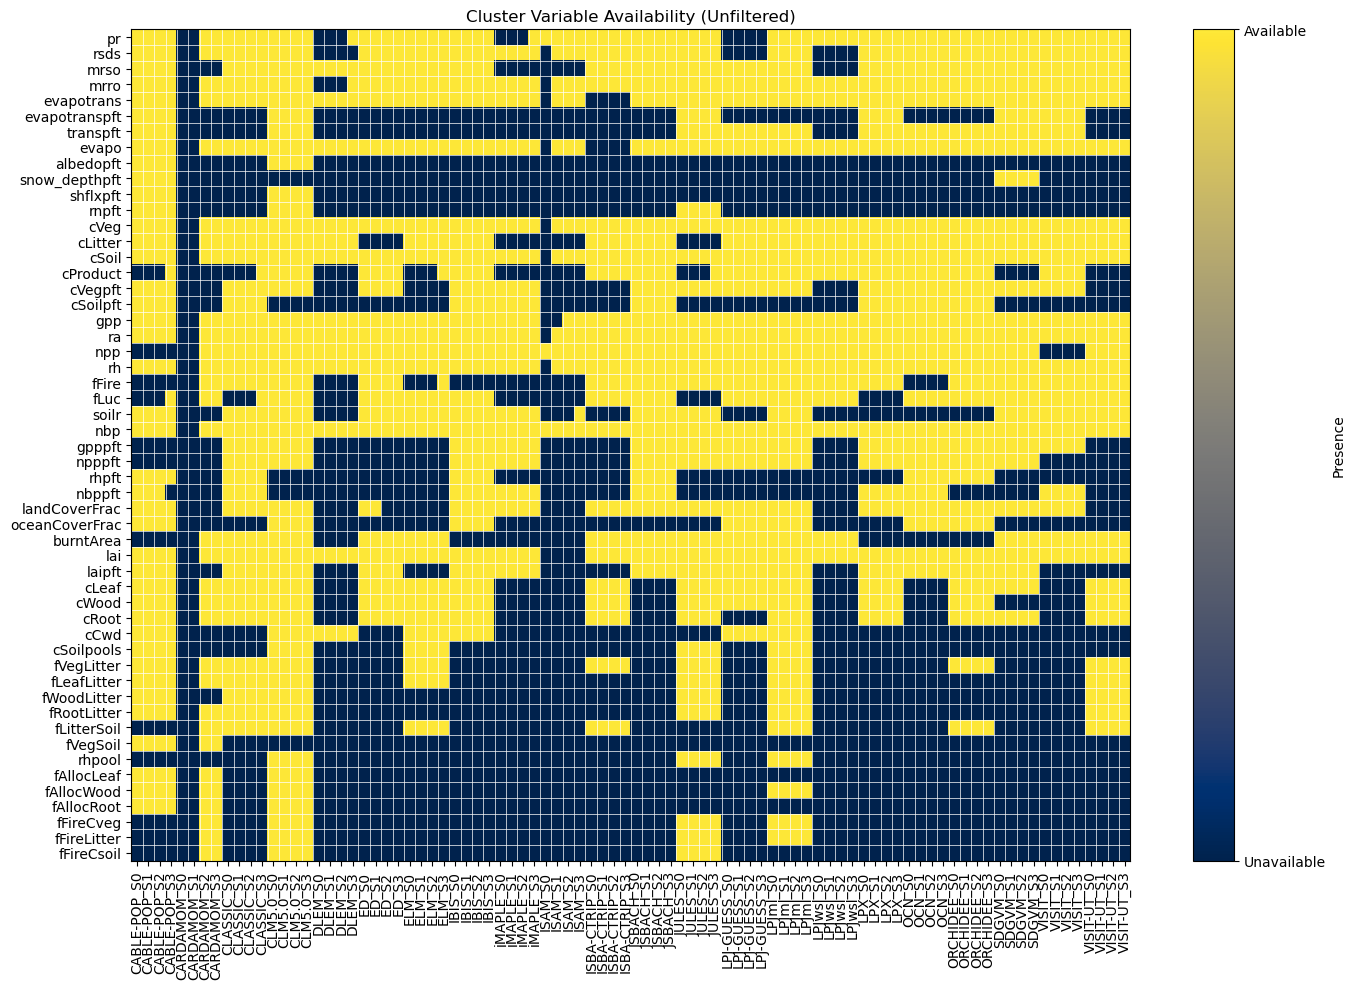

In [72]:
# Convert TRUE/FALSE to integers
plot_data = dict_outcomes['unfiltered'][1].replace({'TRUE': 1, 'FALSE': 0})

plt.figure(figsize=(14, 10))
cmap = plt.get_cmap('cividis')

# Plot heatmap
plt.imshow(plot_data, cmap=cmap, aspect='auto', interpolation='none')

# Tick labels
plt.xticks(ticks=np.arange(plot_data.shape[1]), labels=plot_data.columns, rotation=90)
plt.yticks(ticks=np.arange(plot_data.shape[0]), labels=plot_data.index, rotation=0)

# Add grid lines between cells
for x in range(plot_data.shape[1] + 1):
    plt.axvline(x - 0.5, color='white', linewidth=0.5)
for y in range(plot_data.shape[0] + 1):
    plt.axhline(y - 0.5, color='white', linewidth=0.5)

cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['Unavailable', 'Available'])
cbar.set_label('Presence')


plt.title("Cluster Variable Availability (Unfiltered)")
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, "Unfiltered/Cluster_variables_unfiltered.png"))

plt.show()

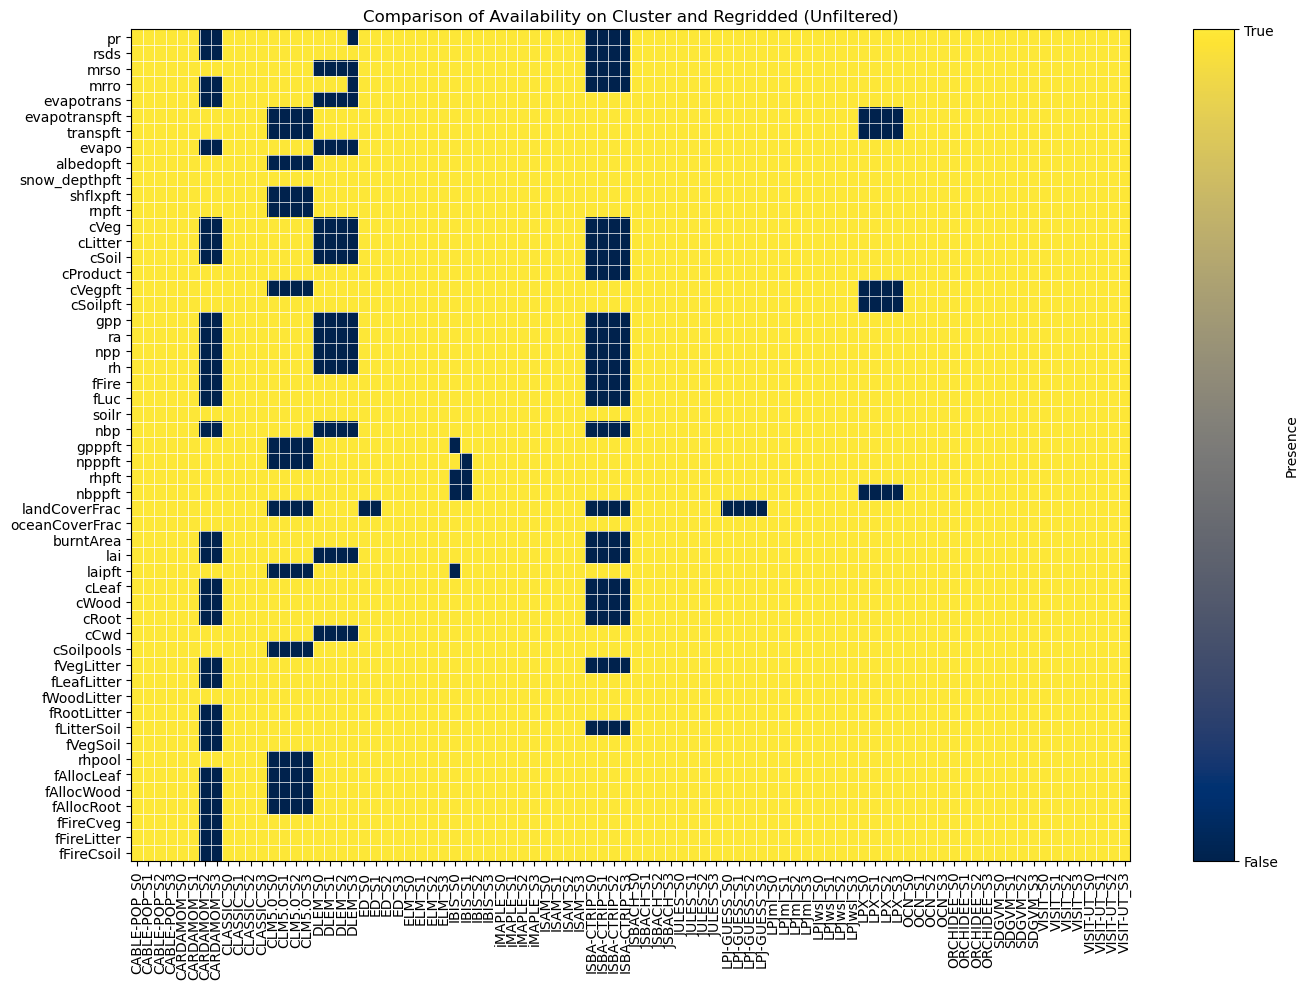

In [73]:
plt.figure(figsize=(14, 10))
cmap = plt.get_cmap('cividis')

# Plot heatmap using boolean values (converted to float for imshow)
plt.imshow(dict_outcomes['unfiltered'][2].values.astype(float), cmap=cmap, aspect='auto', interpolation='none')

# Tick labels
plt.xticks(ticks=np.arange(dict_outcomes['unfiltered'][2].shape[1]), labels=dict_outcomes['unfiltered'][2].columns, rotation=90)
plt.yticks(ticks=np.arange(dict_outcomes['unfiltered'][2].shape[0]), labels=dict_outcomes['unfiltered'][2].index, rotation=0)

# Add grid lines between cells
for x in range(dict_outcomes['unfiltered'][2].shape[1] + 1):
    plt.axvline(x - 0.5, color='white', linewidth=0.5)
for y in range(dict_outcomes['unfiltered'][2].shape[0] + 1):
    plt.axhline(y - 0.5, color='white', linewidth=0.5)

# Colorbar
cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['False', 'True'])
cbar.set_label('Presence')

plt.title("Comparison of Availability on Cluster and Regridded (Unfiltered)")

plt.tight_layout()

plt.savefig(os.path.join(plot_dir, "Unfiltered/Cluster_regridded_match_unfiltered.png"))

plt.show()